In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from datetime import datetime

In [2]:
#Import data def
def gen_df(name):
    file = name+".csv"
    dataframe = pd.read_csv(file)
    dataframe.Date = pd.to_datetime(dataframe.Date, format = "%d/%m/%Y")
    #df.sort_values(by="Date", inplace=True) if data is sorted
    dataframe.set_index("Date",inplace=True)
    #df = df.drop(["VN30_Open", "Set100_Open"], axis =1) #Edit the master file to delete this line!
    return dataframe

In [3]:
#For running new algo
name = input()
df = gen_df(name)

dataset


In [4]:
df

,VNI30,SET100
Date,,
2013-01-02,491.34,2102.10
2013-01-03,498.31,2100.76
2013-01-04,NaN,2113.22
2013-01-07,525.36,2109.78
2013-01-08,531.52,2112.63
...,...,...
2021-01-25,1154.29,2116.40
2021-01-26,1125.09,2134.45
2021-01-27,1083.63,2107.43


In [5]:
#Gen df_Stat df2

def genr_stat(dataframe):
    #Cal VN30/Set100
    dataframe[f'{df.columns[0]}/{dataframe.columns[1]}'] = dataframe[f'{dataframe.columns[0]}'].values.ravel()/dataframe[f'{df.columns[1]}'].values.ravel() #Fix slicing

    #EMA, MACD, Signal
    dataframe['EMA26'] = dataframe[f'{df.columns[0]}/{df.columns[1]}'].ewm(span = 26, adjust=True).mean() #spanday = 26
    dataframe['EMA12'] = dataframe[f'{df.columns[0]}/{df.columns[1]}'].ewm(span = 12, adjust=True).mean() #spanday = 12
    dataframe['MACD'] = dataframe.EMA12 - dataframe.EMA26 #Short-Long

    #Signal Genr and MACD-Signal
    signal_day = 9
    k = 2/(signal_day+1) #Weight of alpha

    #Gern Signal=9
    dataframe['Signal']=np.zeros(len(dataframe.index))
    dataframe['Signal'].iloc[0] = dataframe.MACD.iloc[0] #Zero is Nan

    for t in range(1,len(dataframe.MACD)):
        dataframe['Signal'].iloc[t] = (dataframe.MACD.iloc[t]*k)+(dataframe.Signal[t-1]*(1-k))

    #Shift Signal
    dataframe['Shift_Signal'] = dataframe['Signal'].shift(periods=1)
    dataframe['Shift_Signal'].iloc[0] = dataframe.Signal.iloc[0]
    return dataframe

In [6]:
df_stat = genr_stat(df)
df_stat

,VNI30,SET100,VNI30/SET100,EMA26,EMA12,MACD,Signal,Shift_Signal
Date,,,,,,,,
2013-01-02,491.34,2102.10,0.233738,0.233738,0.233738,0.000000,0.000000,0.000000
2013-01-03,498.31,2100.76,0.237205,0.235538,0.235616,0.000078,0.000016,0.000000
2013-01-04,NaN,2113.22,NaN,0.235538,0.235616,0.000078,0.000028,0.000016
2013-01-07,525.36,2109.78,0.249012,0.240620,0.241385,0.000765,0.000175,0.000028
2013-01-08,531.52,2112.63,0.251592,0.243796,0.244828,0.001032,0.000347,0.000175
...,...,...,...,...,...,...,...,...
2021-01-25,1154.29,2116.40,0.545403,0.524782,0.535647,0.010865,0.011120,0.011184
2021-01-26,1125.09,2134.45,0.527110,0.524954,0.534333,0.009379,0.010772,0.011120
2021-01-27,1083.63,2107.43,0.514195,0.524157,0.531235,0.007078,0.010033,0.010772


In [7]:
#DCA not including Unrealized Value #Type1
def dollar_cost_average(dataframe, dataframe_stat, m_principal, freq=30): #Monthly principal and period,freq =30 days
    
    #Buying Condition
    '''Type1 = Buy VNI30 if Signal>MACD ==> df2['Shift_Signal'].iloc[num] >= df2['MACD'].iloc[num]
       Type2 = Buy Set100 if Signal>MACD ==> df2['Shift_Signal'].iloc[num] <= df2['MACD'].iloc[num]'''
    #Money_daily and monthly investment Date
    daily = m_principal/freq
    print(daily)
    
    #Keep num_VN, num_Set
    num_1, num_2 = [],[]
    
    #Total Balance
    '''Port_val = (accum_VN* current_VNprice)+(accum_Set* current_Setprice)+accum_cash'''
    accum_cash = []
    accum_1stock, accum_2stock = [],[]
    
    
    #Set Dataframe 1= VN, 2= Set
    dataframe['Num_1'] = np.zeros(len(dataframe.index))
    dataframe['Num_2'] = np.zeros(len(dataframe.index))
    dataframe['Accum_1'] = np.zeros(len(dataframe.index))
    dataframe['Accum_2'] = np.zeros(len(dataframe.index))
    dataframe['Port_Val'] = np.zeros(len(dataframe.index))
    dataframe['Cash_Balance'] = np.zeros(len(dataframe.index))
    dataframe['Total_Port'] = np.zeros(len(dataframe.index))
    
    for num in range(0,len(dataframe.index)):
        #Set condition for closing market
        #Both Markets are Opened
        if pd.isna(dataframe_stat[f'{dataframe.columns[0]}'].iloc[num]) != pd.isna(np.nan) and pd.isna(dataframe_stat[f'{dataframe.columns[1]}'].iloc[num]) != pd.isna(np.nan):
            
            #Decision Rules
            #Buy Vn30
            if dataframe_stat['Shift_Signal'].iloc[num] - dataframe_stat['MACD'].iloc[num] >=0:
                dataframe.iloc[num, dataframe.columns.get_loc('Num_1')] = np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])
                num_1.append(np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num]))
                current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])*dataframe[f'{dataframe.columns[0]}'].iloc[num] #Set Current Cash
                accum_cash.append(current_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Accum_1')] = sum(num_1) #Acc_VN
                #Only Holding_Stock Values
                dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num]*sum(num_1) + df[f'{dataframe.columns[1]}'].iloc[num]*sum(num_2)
                dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
                
            #Buy Set100    
            elif dataframe_stat['Shift_Signal'].iloc[num] - dataframe_stat['MACD'].iloc[num] <=0:
                dataframe.iloc[num, dataframe.columns.get_loc('Num_2')] = np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num])
                num_2.append(np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num]))
                current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num])*dataframe[f'{dataframe.columns[1]}'].iloc[num] #Set Current Cash
                accum_cash.append(current_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = sum(num_2) #Acc_VN
                dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num]*sum(num_1) +df[f'{dataframe.columns[1]}'].iloc[num]*sum(num_2)
                dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash)
                dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
            
            else:
                pass
            
        #Condition when Stock1 mrk close
        elif pd.isna(dataframe_stat[f'{dataframe.columns[0]}'].iloc[num]) == pd.isna(np.nan):
            dataframe.iloc[num, dataframe.columns.get_loc('Num_2')] = np.floor(daily/df[f'{dataframe.columns[1]}'].iloc[num])
            num_2.append(np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num]))
            current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[1]}'].iloc[num])*dataframe[f'{dataframe.columns[1]}'].iloc[num] #Set Current Cash
            accum_cash.append(current_cash)
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = sum(num_2) #Acc_VN
            dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num-1]*sum(num_1) + df[f'{dataframe.columns[1]}'].iloc[num]*sum(num_2)
            dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash[:num-1])
            dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
              
        #Condition when Stock2 mrk close
        elif pd.isna(dataframe_stat[f'{dataframe.columns[1]}'].iloc[num]) == pd.isna(np.nan):
            dataframe.iloc[num, dataframe.columns.get_loc('Num_1')] = np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])
            num_1.append(np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num]))
            current_cash = daily - np.floor(daily/dataframe[f'{dataframe.columns[0]}'].iloc[num])*dataframe[f'{dataframe.columns[0]}'].iloc[num] #Set Current Cash
            accum_cash.append(current_cash)
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_1')] = sum(num_1) #Acc_VN
            dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe[f'{dataframe.columns[0]}'].iloc[num]*sum(num_1) +dataframe[f'{dataframe.columns[1]}'].iloc[num-1]*sum(num_2)
            dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash[:num-1])
            dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
        
        #Condition when two market close
        elif pd.isna(dataframe_stat[f'{dataframe.columns[0]}'].iloc[num] == pd.isna(np.nan)) and pd.isna(dataframe_stat[f'{dataframe.columns[1]}'].iloc[num] == pd.isna(np.nan)):
            accum_cash.append(0)
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_1')] = num_1[num-1] #Acc_1
            dataframe.iloc[num, dataframe.columns.get_loc('Accum_2')] = num_2[num-1] #Acc_1
            dataframe.iloc[num, dataframe.columns.get_loc('Port_Val')] = dataframe.Port_Val.iloc[num-1]
            dataframe.iloc[num, dataframe.columns.get_loc('Cash_Balance')] = sum(accum_cash)
            dataframe.iloc[num, dataframe.columns.get_loc('Total_Port')] = dataframe['Port_Val'].iloc[num] + dataframe['Cash_Balance'].iloc[num]
    
    return dataframe, accum_cash

#Remark
#pd.isna(df2['Set100_ClosePrice'].iloc[1237]) == pd.isna(np.nan)

In [8]:
df = gen_df(name)

In [9]:
result, acc_cash = dollar_cost_average(df, genr_stat(df), 100000) #monthly by 100000

3333.3333333333335


In [10]:
result

,VNI30,SET100,VNI30/SET100,EMA26,EMA12,MACD,Signal,Shift_Signal,Num_1,Num_2,Accum_1,Accum_2,Port_Val,Cash_Balance,Total_Port
Date,,,,,,,,,,,,,,,
2013-01-02,491.34,2102.10,0.233738,0.233738,0.233738,0.000000,0.000000,0.000000,6.0,0.0,6.0,0.0,2948.04,3.852933e+02,3.333333e+03
2013-01-03,498.31,2100.76,0.237205,0.235538,0.235616,0.000078,0.000016,0.000000,0.0,1.0,0.0,1.0,5090.62,1.617867e+03,6.708487e+03
2013-01-04,NaN,2113.22,NaN,0.235538,0.235616,0.000078,0.000028,0.000016,0.0,1.0,0.0,2.0,7216.30,3.852933e+02,7.601593e+03
2013-01-07,525.36,2109.78,0.249012,0.240620,0.241385,0.000765,0.000175,0.000028,0.0,1.0,0.0,3.0,9481.50,4.061533e+03,1.354303e+04
2013-01-08,531.52,2112.63,0.251592,0.243796,0.244828,0.001032,0.000347,0.000175,0.0,1.0,0.0,4.0,11639.64,5.282237e+03,1.692188e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,1154.29,2116.40,0.545403,0.524782,0.535647,0.010865,0.011120,0.011184,2.0,0.0,3626.0,0.0,6570638.34,1.565835e+06,8.136474e+06
2021-01-26,1125.09,2134.45,0.527110,0.524954,0.534333,0.009379,0.010772,0.011120,2.0,0.0,3628.0,0.0,6487351.67,1.566918e+06,8.054270e+06
2021-01-27,1083.63,2107.43,0.514195,0.524157,0.531235,0.007078,0.010033,0.010772,3.0,0.0,3631.0,0.0,6309734.14,1.567001e+06,7.876735e+06


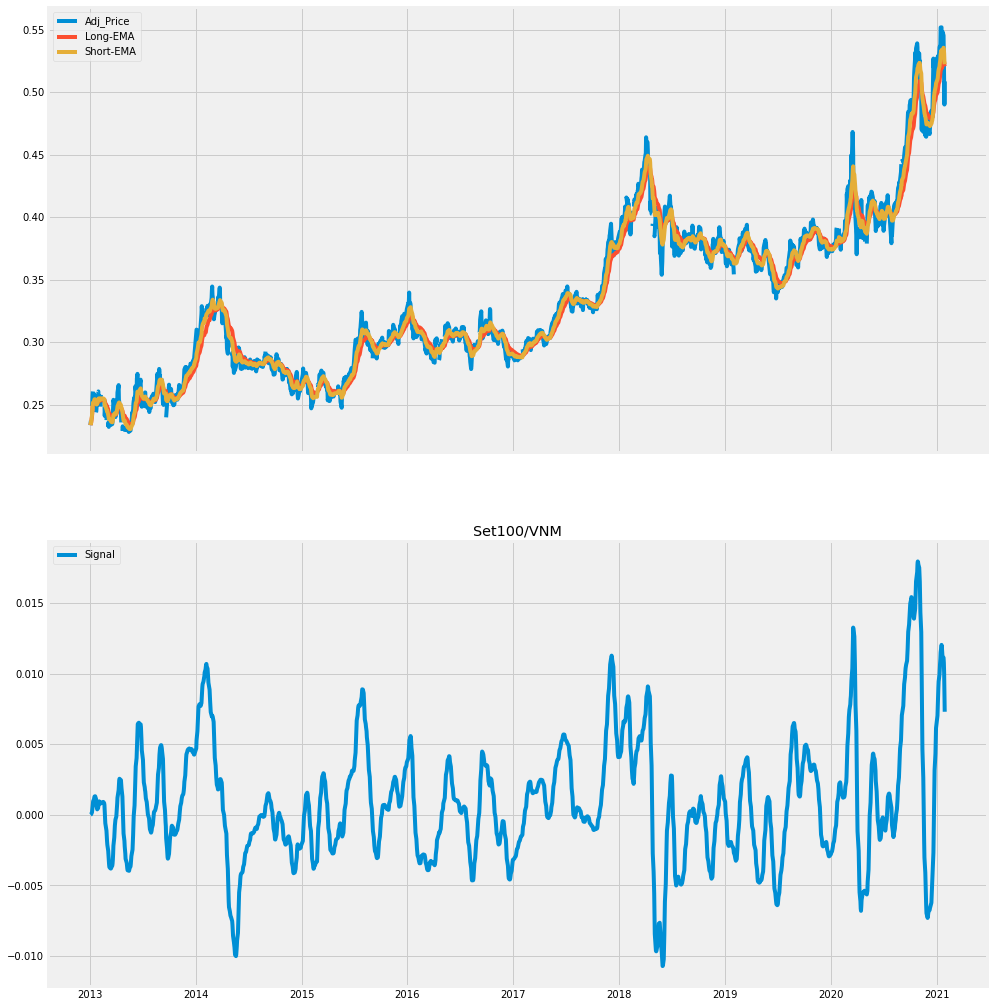

In [11]:
#Vizualization
fig1,ax = plt.subplots(2, sharex=True,figsize= (15,20))
#Plot Upper
ax[0].plot(df[f'{df.columns[0]}/{df.columns[1]}'],label= "Adj_Price")
df.EMA26.plot(ax=ax[0],kind='line' ,label='Long-EMA',)
df.EMA12.plot(ax=ax[0],kind='line' ,label='Short-EMA')
ax[0].legend(loc = 'upper left')

#Plot Lower
ax[1].plot(df['Signal'],label = "Signal")
ax[1].legend(loc = 'upper left')
plt.title('Set100/VNM')
plt.show()

## Summary Stat Key

## Max_Min

In [12]:
def Min_Max_Val(Port_Val:pd.Series, Total_Port,Price:pd.Series): #Add series
    Max_Port, date_max_Port = Port_Val.max(), Port_Val.idxmax().strftime("%d/%m/%y") #Max Port Value
    Min_Port, date_min_Port = Port_Val.min(), Port_Val.idxmin().strftime("%d/%m/%y") #Min Port value
    Max_Total_Value, date_max_Value = Total_Port.max(), Total_Port.idxmax().strftime("%d/%m/%y") #Max Total Port
    Min_Total_Value, date_min_Value = Total_Port.min(), Total_Port.idxmin().strftime("%d/%m/%y")
    Max_Price, date_max_Price = Price.max(), Price.idxmax().strftime("%d/%m/%y")
    Min_Price, date_min_Price = Price.min(), Price.idxmin().strftime("%d/%m/%y")
    print("           MAX (Date)                   MIN (Date)    ")
    print("--------------------------------------------------------------")
    print(f"Port   |   {Max_Port:.4f}; {date_max_Port:}     {Min_Port:.4f}; {date_min_Port}")
    print(f"Value  |   {Max_Total_Value:.4f}; {date_max_Value}     {Min_Total_Value:.4f}; {date_min_Value}")
    print(f"Price  |   {Max_Price:.4f};       {date_max_Price}     {Min_Price:.4f};    {date_min_Price}")

In [13]:
Min_Max_Val(result.Port_Val, result.Total_Port, result['VNI30/SET100'])

           MAX (Date)                   MIN (Date)    
--------------------------------------------------------------
Port   |   6685770.2000; 15/01/21     2948.0400; 02/01/13
Value  |   8246209.9733; 15/01/21     3333.3333; 02/01/13
Price  |   0.5519;       18/01/21     0.2283;    14/05/13


## Maximum Drawdown

In [28]:
def Rolling_Drawdown(dataframe, window):
    
    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dataframe[f'{dataframe.columns[2]}'].rolling(window, min_periods=1).max()
    Daily_Drawdown = dataframe[f'{dataframe.columns[2]}']/Roll_Max - 1.0
    
    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown =Daily_Drawdown.rolling(window, min_periods = 1).min()
    
    # Plot the results
    Daily_Drawdown.plot(figsize=(15,10))
    Max_Daily_Drawdown.plot()
    plt.title("Annually Maximum Drawdown")
    plt.show()
    return Max_Daily_Drawdown.min()*100

In [15]:
def Results(annuity, dataframe):
    daily = annuity/30
    Total_Cash = len(dataframe.index)*daily
    Profit = dataframe['Total_Port'].iloc[len(dataframe.index)-1] - Total_Cash
    Percent_Profit = 100*Profit/Total_Cash
    num_year = len(dataframe)/252 #window
    print(f"Remark: {num_year:.2f} years DCA based on MACD Signal selection {dataframe.columns[2]}")
    print(f"Annuity: {annuity} per 30 days, daily = {daily:.4f} bath, Total Day = {len(dataframe)} Days")
    print("----------------------------------")
    print(f"   Last Day       {dataframe.columns[0]}    {dataframe.columns[1]}")
    print("----------------------------------")
    print(f"Number of Stock| {dataframe.Accum_1.max()}     {dataframe.Accum_2.max()}")
    print(f"Port Value     | {dataframe.Port_Val.iloc[len(dataframe.index)-1]:.4f}" )
    print(f"Cash Balance   | {dataframe.Cash_Balance.iloc[len(dataframe.index)-1]:.4f}")
    print(f"Total_Port     | {dataframe.Total_Port.iloc[len(dataframe.index)-1]:.4f}")
    print(f"Initail Invest | {Total_Cash:.4f}")
    print(f"Total Profit   | {Profit:.4f}")
    print(f"% Total Profit | {Percent_Profit:.4f}"+"%")
    print(f"Maximum Drawdown-All period: {Rolling_Drawdown(dataframe,252):.4f}")

Remark: 7.83 years DCA based on MACD Signal selection VNI30/SET100
Annuity: 100000 per 30 days, daily = 3333.3333 bath, Total Day = 1973 Days
----------------------------------
   Last Day       VNI30    SET100
----------------------------------
Number of Stock| 3637.0     1127.0
Port Value     | 6135056.0200
Cash Balance   | 1567490.2967
Total_Port     | 7702546.3167
Initail Invest | 6576666.6667
Total Profit   | 1125879.6500
% Total Profit | 17.1193%


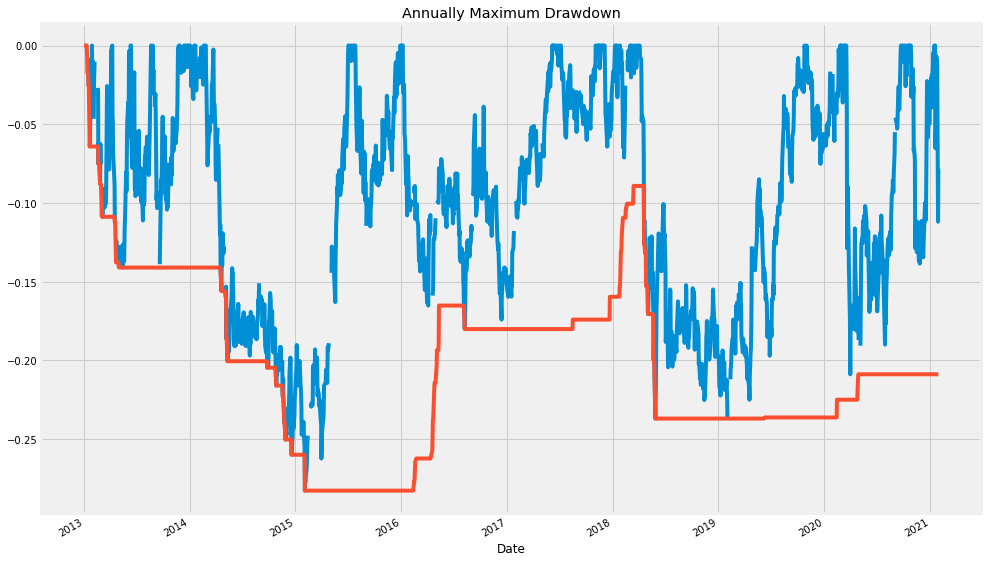

Maximum Drawdown-All period: -28.2790


In [29]:
Results(100000,result)

## Sharpe Ratio

In [17]:
#Sharpe Ratio #Dialy return(array)
#Return = Price
def sharpe(returns, rf, days=252): #trading day = 252, return = (price_t - price_t-1)/Std(return)
    volatility = returns.std() * np.sqrt(days)
    sharpe_ratio = (returns.mean() - rf) / volatility
    return sharpe_ratio, volatility

### Portfolio Optimization(Markowit Thoery)

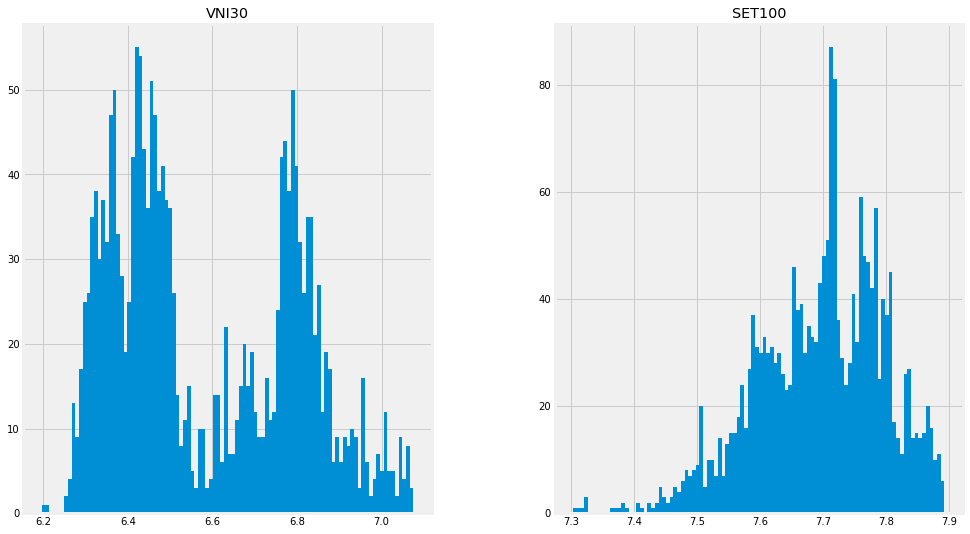

In [19]:
data = gen_df(name)
log_data = data.apply(np.log) #Log_transformation
log_data.hist(bins=100,figsize=(15,9)) #Plot normal Price
plt.show()

In [20]:
#Calculate mean, std
def Mean_STD(log_return):
    mean_log_re,std_log_re = log_return.mean(), log_return.std()
    return mean_log_re,std_log_re

In [21]:
mean_port, std_port = Mean_STD(log_data)

In [22]:
mean_port, std_port

(VNI30     6.583551
 SET100    7.695254
 dtype: float64,
 VNI30     0.212391
 SET100    0.101160
 dtype: float64)

In [23]:
#Gern Covariance Matrix and Correlation
def Cov_Corr(log_return):
    cov_return=log_return.cov()*252
    corr_return = log_return.corr()
    return cov_return, corr_return

In [24]:
Cov_port, Corr_port = Cov_Corr(log_data)

In [25]:
Cov_port

,VNI30,SET100
VNI30,11.367687,2.664206
SET100,2.664206,2.578799


In [26]:
Corr_port

,VNI30,SET100
VNI30,1.000000,0.492365
SET100,0.492365,1.000000


In [27]:
#Random weight for init a port
np.random.seed(101) #Set the same random
print(data.columns)

#weight of Port
w = np.array(np.random.random(2))
print(f"Random Weights: {w}")
print("-----")

#Rebalance W
w_stad = w/np.sum(w)
print(f"Rebalance Weight: {w_stad}")
print("-----")

#Expected Return
print("Expected Port Return")
exp_re = np.sum((mean_port*w_stad)*252)
print(exp_re)

#Expencted volatility
exp_vol = np.sqrt(np.dot(w.T ,np.dot(Cov_port*252,w)))
print('Expected Volatility')
print(exp_vol)

#Expected Sharp Ratio
sr = exp_re/exp_vol
print("Sharp Ratio")
print(sr)

Index(['VNI30', 'SET100'], dtype='object')
Random Weights: [0.51639863 0.57066759]
-----
Rebalance Weight: [0.4750388 0.5249612]
-----
Expected Port Return
1806.1223485643882
Expected Volatility
37.030328029674294
Sharp Ratio
48.77413851470746


# Annual Rolling

In [ ]:
round(len(df)/252) #window is set to 252

In [ ]:
data = gen_df(name)

In [ ]:
#Slicing to 2 year and 0.89 (11 month)
df1 = data[:window]
df2 = data[window:window*2]
df3 = data[window*2:window*3]

In [ ]:
result1, acc_cash1 = dollar_cost_average(df1, genr_stat(df1), 100000)
result2, acc_cash2 = dollar_cost_average(df2, genr_stat(df2), 100000)
result3, acc_cash3 = dollar_cost_average(df3, genr_stat(df3), 100000)

In [ ]:
Rolling_Drawdown(df1,252)

In [ ]:
Rolling_Drawdown(df2,252)

In [ ]:
Rolling_Drawdown(df3,252)